<a href="https://colab.research.google.com/github/thaicoh/DataMining_LicensePlateRecognition/blob/main/LicensePlateRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import các thư viện cần thiết

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import os
import tensorflow as tf
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

import cv2
from ultralytics import YOLO
from imutils import perspective
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import imutils # Import the imutils library
from skimage import measure  # Import the measure module from skimage


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **I. Xây dựng mô hình YOLOv8 để nhận diện vùng chứa biển số xe**


### 1.1 Setup YOLOv8

In [ ]:
# Tải thư viện ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 13.5 MB/s eta 0:00:00


### 1.2 Setup datasets folder to training custom object

In [ ]:
import os
import shutil
import random

# Đường dẫn đến thư mục chứa dữ liệu đã xuất ra
exported_path = '/content/drive/MyDrive/Yolov8/project-4-at-2024-10-17-23-44-5c31c180'  # Thay đổi đường dẫn này
# Đường dẫn đến thư mục datasets mới
datasets_path = '/content/dataset'

# Tạo cấu trúc thư mục
os.makedirs(os.path.join(datasets_path, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(datasets_path, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(datasets_path, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(datasets_path, 'labels', 'val'), exist_ok=True)

# Lấy danh sách tất cả các file ảnh và label
image_files = [f for f in os.listdir(os.path.join(exported_path, 'images'))
               if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'))]
label_files = [f for f in os.listdir(os.path.join(exported_path, 'labels')) if f.endswith('.txt')]

print(len(image_files))

# Kiểm tra xem số lượng ảnh và label có khớp nhau không
assert len(image_files) == len(label_files), "Số lượng ảnh và label không khớp."

# Tạo danh sách phân chia 30% cho val và 70% cho train
random.shuffle(image_files)
split_index = int(0.7 * len(image_files))
train_files = image_files[:split_index]
val_files = image_files[split_index:]

# Sao chép file ảnh và label vào thư mục tương ứng cho tập train
for img_file in train_files:
    # Sao chép file ảnh
    shutil.copy(os.path.join(exported_path, 'images', img_file), os.path.join(datasets_path, 'images', 'train', img_file))

    # Xử lý tên file label tương ứng
    label_file = os.path.splitext(img_file)[0] + '.txt'
    shutil.copy(os.path.join(exported_path, 'labels', label_file), os.path.join(datasets_path, 'labels', 'train', label_file))

# Sao chép file ảnh và label vào thư mục tương ứng cho tập val
for img_file in val_files:
    # Sao chép file ảnh
    shutil.copy(os.path.join(exported_path, 'images', img_file), os.path.join(datasets_path, 'images', 'val', img_file))

    # Xử lý tên file label tương ứng
    label_file = os.path.splitext(img_file)[0] + '.txt'
    shutil.copy(os.path.join(exported_path, 'labels', label_file), os.path.join(datasets_path, 'labels', 'val', label_file))

print("Hoàn tất việc tạo thư mục datasets.")


140
Hoàn tất việc tạo thư mục datasets.


In [ ]:

!yolo train model=yolov8n.pt data=/content/mycg.yaml epochs=50 imgsz=640

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/mycg.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

### 1.2 Load trained model and test

In [ ]:
from ultralytics import YOLO

model = YOLO("/content/best (1).pt")

# Train the model using the 'coco8.yaml' dataset for 3 epochs
!yolo task=detect mode=predict model="/content/best (1).pt" source="https://xefordvietnam.com/wp-content/uploads/ford-ranger-wiltrak-3-2-bien-so-dep.png"

In [ ]:
# Load the trained model
model = YOLO('/content/drive/MyDrive/Yolov8/best_final.pt')

# Perform prediction on an image
results = model.predict(source="https://autopro8.mediacdn.vn/2022/5/23/ranger-ngu-quy-vang-1653299881034300623452-crop-165329996714977038366.jpeg", save=True)

# Extract points (bounding boxes) from the prediction
for result in results:
    boxes = result.boxes.xyxy  # This contains [x1, y1, x2, y2] coordinates of bounding boxes
    scores = result.boxes.conf  # Confidence scores for each prediction
    classes = result.boxes.cls  # Class ids for each prediction

    print("Bounding Boxes:")
    print(boxes)
    print("Confidence Scores:")
    print(scores)
    print("Class IDs:")
    print(classes)



Found https://autopro8.mediacdn.vn/2022/5/23/ranger-ngu-quy-vang-1653299881034300623452-crop-165329996714977038366.jpeg locally at ranger-ngu-quy-vang-1653299881034300623452-crop-165329996714977038366.jpeg
image 1/1 /content/ranger-ngu-quy-vang-1653299881034300623452-crop-165329996714977038366.jpeg: 448x640 2 bien_sos, 25.8ms
Speed: 3.8ms preprocess, 25.8ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict2
Bounding Boxes:
tensor([[1668.7629,  866.7678, 1837.0453,  948.6058],
        [ 280.3021,  888.7470,  440.5953,  973.3608]], device='cuda:0')
Confidence Scores:
tensor([0.8911, 0.6374], device='cuda:0')
Class IDs:
tensor([0., 0.], device='cuda:0')


# **II. Segment tách từng kí tự trên biến số xe**

### 2.1 Dùng YOLOv8 để nhận hiện vùng chưa biển số

In [ ]:
# Tải lại model YOLOv8 đã được train
model_yolo = YOLO('/content/drive/MyDrive/Yolov8/best_final.pt')

# Tải ảnh từ url
url = "https://phimcachnhiet.com.vn/wp-content/uploads/2023/10/bien-so-xe-phong-thuy-3-1024x554.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Chuyển ảnh từ RGBA sang RGB nếu cần
if img.mode == 'RGBA':
    img = img.convert('RGB')

img_np = np.array(img)

# Dưa ảnh đã tải và mô hình YOLO để dự đoán
results = model_yolo.predict(source=img, save=True)


0: 352x640 1 bien_so, 10.3ms
Speed: 2.7ms preprocess, 10.3ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/predict4


::Lệnh `results = model_yolo.predict(source=img, save=True)` trả về các dự đoán YOLO trên ảnh `img`, bao gồm:

1. **Bounding Boxes**: Tọa độ và kích thước của hộp giới hạn quanh các đối tượng được nhận diện.
2. **Nhãn (Labels)**: Loại đối tượng (như "person", "car", v.v.) của mỗi hộp.
3. **Độ tin cậy (Confidence)**: Độ chắc chắn của model về mỗi đối tượng, giá trị từ `0` đến `1`.

Với `save=True`, ảnh chứa dự đoán sẽ được lưu vào thư mục `runs/predict`.


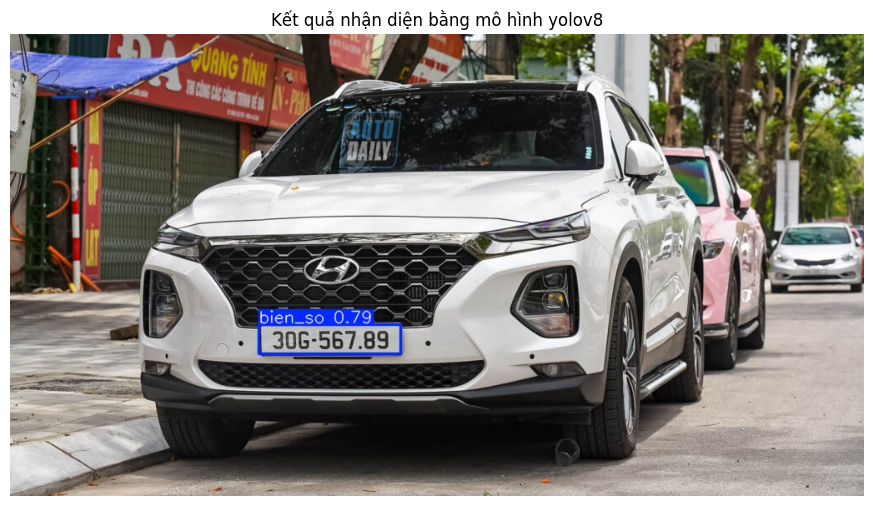

In [ ]:
# Đường dẫn đến thư mục
save_dir = results[0].save_dir  # Nếu 'save_dir' nằm trong phần tử đầu tiên
files = os.listdir(save_dir)

imgPredict = Image.open("/content/"+save_dir +"/"+ files[0])

# Hiển thị ảnh
plt.figure(figsize=(12, 6))
plt.imshow(imgPredict)
plt.axis('off')  # Tắt hiển thị trục
plt.title('Kết quả nhận diện bằng mô hình yolov8')
# Tắt chế độ hiển thị văn bản phụ
plt.show(block=False)

### 2.2 Tách vùng chứa biển số ra thành 1 ảnh riêng biệt

In [ ]:
# Trích xuất bounding boxes từ kết quả dự đoán
for i, result in enumerate(results):
    boxes = result.boxes.xyxy  # Lấy tọa độ bounding box: [x1, y1, x2, y2]
    scores = result.boxes.conf  # Lấy confidence cho mỗi box
    classes = result.boxes.cls  # Lấy class ids cho mỗi box

    # Giả sử lấy box đầu tiên
    if len(boxes) > 0:
        box = boxes[i].cpu().numpy().astype(int)

        # Tạo toạ độ các điểm góc [top-left, top-right, bottom-right, bottom-left]
        pts = np.array([[box[0], box[1]], [box[2], box[1]], [box[2], box[3]], [box[0], box[3]]], dtype="float32")

        # Áp dụng phép biến đổi phối cảnh
        LpRegion = perspective.four_point_transform(img_np, pts)

        original_height, original_width = LpRegion.shape[:2]

        # Tính tỷ lệ thay đổi chiều rộng
        ratio = 200 / original_width

        # Tính chiều cao mới dựa trên tỷ lệ đã tính
        new_height = int(original_height * ratio)

        # Resize ảnh về kích thước mới (giữ nguyên tỷ lệ)
        LpRegion = cv2.resize(LpRegion, (200, new_height), interpolation=cv2.INTER_AREA)

        # Hiển thị hoặc lưu kết quả
        cv2.imwrite("/content/cropped_lp.jpg", LpRegion)
        print("Biển số xe đã được lưu.")


Biển số xe đã được lưu.


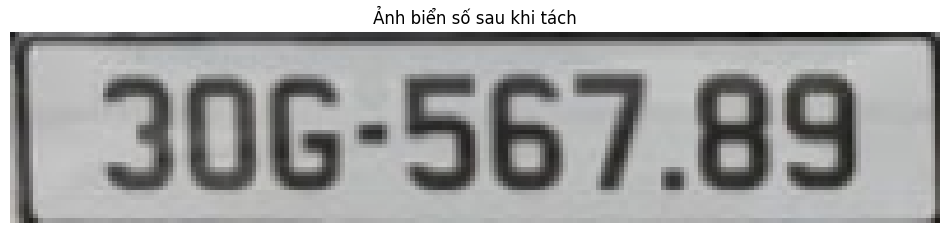

In [ ]:
    # Hiển thị ảnh biển số sau khi tách
    plt.figure(figsize=(12, 6))
    plt.imshow(LpRegion, cmap='gray')
    plt.axis('off')  # Tắt hiển thị trục
    plt.title('Ảnh biển số sau khi tách')
    plt.show(block=False)

image0.jpg


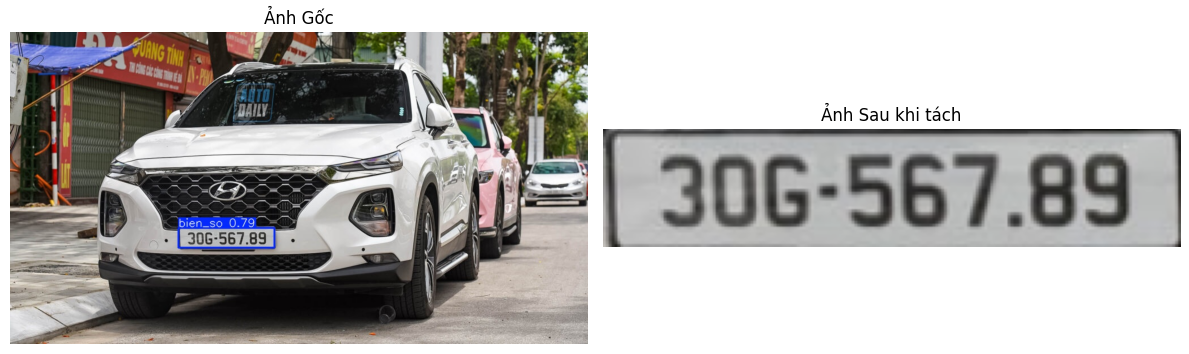

In [ ]:
    # Đường dẫn đến thư mục
    save_dir = results[0].save_dir  # Nếu 'save_dir' nằm trong phần tử đầu tiên

    # Liệt kê các file trong thư mục
    files = os.listdir(save_dir)

    # In ra các file ảnh
    for file in files:
        print(file)

    imgPredict = Image.open("/content/"+save_dir +"/"+ file)

    # Giả sử 'thresh' là ảnh nhị phân và 'original' là ảnh gốc đã được tạo từ đoạn mã trước
    plt.figure(figsize=(12, 6))

    # Hiển thị ảnh gốc
    plt.subplot(1, 2, 1)  # 1 hàng, 2 cột, ảnh thứ 1
    plt.imshow(imgPredict)
    plt.axis('off')  # Tắt hiển thị trục
    plt.title('Ảnh Gốc')

    # Hiển thị ảnh nhị phân
    plt.subplot(1, 2, 2)  # 1 hàng, 2 cột, ảnh thứ 2
    plt.imshow(LpRegion, cmap='gray')
    plt.axis('off')  # Tắt hiển thị trục
    plt.title('Ảnh Sau khi tách')

    plt.tight_layout()  # Tối ưu hóa khoảng cách giữa các ảnh
    plt.show()

### 2.3 Dùng phương pháp Adaptive Thresholding để làm nổi bật các ký tự

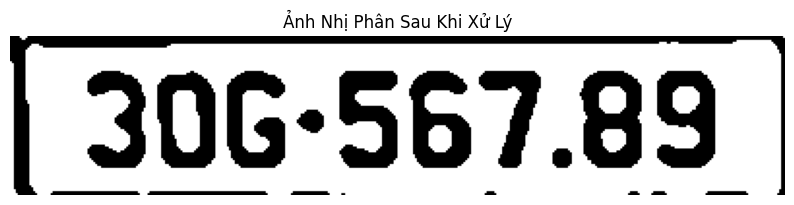

In [ ]:
image = LpRegion

# Nếu LpRegion là ảnh màu, chuyển đổi sang ảnh xám
if len(image.shape) == 3:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Áp dụng Adaptive Thresholding
adaptive_threshold = cv2.adaptiveThreshold(
    image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # cv2.ADAPTIVE_THRESH_MEAN_C
    cv2.THRESH_BINARY,
    31,  # Kích thước của vùng lân cận
    2    # Hằng số được trừ từ giá ôm trị trung bình
)

adaptive_threshold = cv2.bitwise_not(adaptive_threshold) # Đảo màu ảnh
adaptive_threshold = imutils.resize(adaptive_threshold, width=400)  # Resize ảnh
adaptive_threshold = cv2.medianBlur(adaptive_threshold, 5)  # Làm mượt ảnh



imgToShow = cv2.bitwise_not(adaptive_threshold)

# Giả sử 'thresh' là ảnh nhị phân đã được tạo từ đoạn mã trước
plt.figure(figsize=(10, 6))
plt.imshow(imgToShow, cmap='gray')
plt.axis('off')  # Tắt hiển thị trục
plt.title('Ảnh Nhị Phân Sau Khi Xử Lý')
plt.show()

### 2.4 Sử dụng "Connected Components Analysis" để tách các phần có thể là ký tự

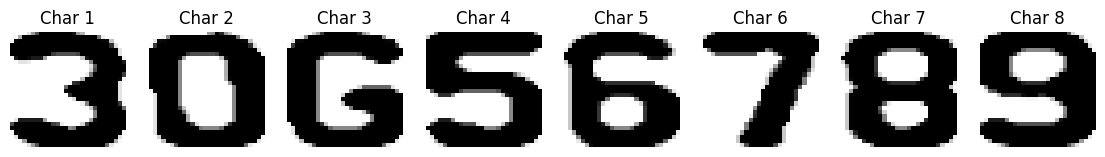

In [ ]:
# connected components analysis
labels = measure.label(adaptive_threshold, connectivity=2, background=0)

# Khởi tạo danh sách để lưu các ký tự
candidates = []

# Vòng lặp qua các thành phần duy nhất
for label in np.unique(labels):
    if label == 0:
        continue

    mask = np.zeros(adaptive_threshold.shape, dtype="uint8")
    mask[labels == label] = 255

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        contour = max(contours, key=cv2.contourArea)
        (x, y, w, h) = cv2.boundingRect(contour)

        aspectRatio = w / float(h)
        solidity = cv2.contourArea(contour) / float(w * h)
        heightRatio = h / float(LpRegion.shape[0])

        if 0.2 < aspectRatio < 1.0 and solidity > 0.1 and 0.35 < heightRatio < 2.0:
            candidate = np.array(mask[y:y + h, x:x + w])
            candidate = cv2.bitwise_not(candidate)
            candidates.append((candidate, (y, x, w, h)))

# Tính chiều cao trung bình từ thông tin kích thước
heights = [dim[3] for _, dim in candidates]  # Lấy chiều cao từ tuple (y, x, w, h)
average_height = np.mean(heights)

# Lọc các ký tự dựa trên chiều cao
filtered_candidates = [
    (char, dim) for char, dim in candidates
    if (2/3) * average_height <= dim[3] <= 2 * average_height
]

# Hiển thị từng ký tự trong filtered_candidates
plt.figure(figsize=(14, 10))
for idx, (char_image, _ ) in enumerate(filtered_candidates):
    # char_image = convert2Square(char_image)
    char_image = cv2.resize(char_image, (28, 28), cv2.INTER_AREA)
    char_image = char_image.reshape((28, 28, 1))

    plt.subplot(1, len(filtered_candidates), idx + 1)
    plt.imshow(char_image.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f'Char {idx + 1}')
plt.show()

### 2.5 Save data các ký tự để cải thiện model cnn dự đoán

- Do dataset thu thập được không phù hợp với bộ dữ liệu biển số xe Việt Nam (do khác phông chữ..). Nên bước này nhằm thu thập thêm dữ liệu cho bộ dataset cũ.
- Các ký tự ở bước trên sau khi được tách thành công sẽ được đưa lưu vào folder trên drive thông qua hàm saveToDataset(string) với chuỗi string là thứ tự sắp xếp của các ký tự sau khi được tách
 - ví dụ: saveToDataset("37A55555*") trong đó "*" là ảnh nhiễu. Ảnh đầu tiên sẽ được lưu vào folder "3", ... và ảnh cuối sẽ được lưu vào folder "Bg".

In [ ]:
import cv2
import numpy as np
import os
from datetime import datetime

def saveToDataset(string):
  char_list = list(string)
  # In ra ký tự cùng với chỉ số của nó
  for index, char in enumerate(char_list):

    if(char == "*"):
      char="Bg"

    # Lấy char_image từ candidates
    char_image = filtered_candidates[index][0]  # Lấy char_image từ tuple

    # Đường dẫn nơi bạn muốn lưu ảnh
    folder_path = f'/content/drive/MyDrive/Yolov8/dataset_1/{char}'  # Đường dẫn folder chứa ký tự
    os.makedirs(folder_path, exist_ok=True)  # Tạo folder nếu chưa tồn tại

    # Tạo tên file với timestamp để đảm bảo không bị trùng
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')  # Thời gian hiện tại
    filename = f'char_image_{timestamp}_{index}.png'  # Tên file

    # Lưu ảnh
    save_path = os.path.join(folder_path, filename)  # Đường dẫn hoàn chỉnh
    if char_image.dtype != np.uint8:
        char_image = (char_image * 255).astype(np.uint8)  # Chuyển đổi kiểu dữ liệu

    cv2.imwrite(save_path, char_image)  # Lưu ảnh

    print(f"Ảnh tại index {index} đã được lưu tại: {save_path}")

In [ ]:
saveToDataset("37A55555")

Ảnh tại index 0 đã được lưu tại: /content/drive/MyDrive/Yolov8/dataset_1/3/char_image_20241025_185947_0.png
Ảnh tại index 1 đã được lưu tại: /content/drive/MyDrive/Yolov8/dataset_1/7/char_image_20241025_185948_1.png
Ảnh tại index 2 đã được lưu tại: /content/drive/MyDrive/Yolov8/dataset_1/A/char_image_20241025_185949_2.png
Ảnh tại index 3 đã được lưu tại: /content/drive/MyDrive/Yolov8/dataset_1/5/char_image_20241025_185949_3.png
Ảnh tại index 4 đã được lưu tại: /content/drive/MyDrive/Yolov8/dataset_1/5/char_image_20241025_185950_4.png
Ảnh tại index 5 đã được lưu tại: /content/drive/MyDrive/Yolov8/dataset_1/5/char_image_20241025_185950_5.png
Ảnh tại index 6 đã được lưu tại: /content/drive/MyDrive/Yolov8/dataset_1/5/char_image_20241025_185950_6.png
Ảnh tại index 7 đã được lưu tại: /content/drive/MyDrive/Yolov8/dataset_1/5/char_image_20241025_185950_7.png


### 2.6 Đóng gói thành hàm xử lý tách ký tự

In [ ]:

# Load YOLO model /content/drive/MyDrive/Yolov8/best (1).pt,
model_yolo = YOLO('/content/drive/MyDrive/Yolov8/best_final.pt')

def predict_object(model, url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # Kiểm tra chiều rộng của ảnh
    width, height = img.size
    # if width > 1000:
    #     ratio = 1000 / width
    #     new_height = int(height * ratio)

        # Resize ảnh
        # img = img.resize((1000, new_height), Image.LANCZOS)
    # Chuyển ảnh từ RGBA sang RGB nếu cần
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    img_np = np.array(img)

    # Dự đoán trên ảnh
    results = model.predict(source=img, save=True)

    # Trích xuất bounding boxes từ kết quả dự đoán
    for i, result in enumerate(results):
        boxes = result.boxes.xyxy  # Lấy tọa độ bounding box: [x1, y1, x2, y2]
        scores = result.boxes.conf  # Lấy confidence cho mỗi box
        classes = result.boxes.cls  # Lấy class ids cho mỗi box

        # Giả sử bạn muốn lấy box đầu tiên
        if len(boxes) > 0:
            box = boxes[0].cpu().numpy().astype(int)

            # Tạo toạ độ các điểm góc [top-left, top-right, bottom-right, bottom-left]
            pts = np.array([[box[0], box[1]], [box[2], box[1]], [box[2], box[3]], [box[0], box[3]]], dtype="float32")

            # Áp dụng phép biến đổi phối cảnh
            LpRegion = perspective.four_point_transform(img_np, pts)

            original_height, original_width = LpRegion.shape[:2]

            # Đặt chiều rộng mới là 200px
            new_width = 200

            # Tính tỷ lệ thay đổi chiều rộng
            ratio = new_width / original_width

            # Tính chiều cao mới dựa trên tỷ lệ đã tính
            new_height = int(original_height * ratio)

            # Resize ảnh về kích thước mới (giữ nguyên tỷ lệ)
            LpRegion = cv2.resize(LpRegion, (new_width, new_height), interpolation=cv2.INTER_AREA)

            # Hiển thị hoặc lưu kết quả
            cv2.imwrite("/content/cropped_lp.jpg", LpRegion)
            print("Biển số xe đã được lưu.")

    # Đường dẫn đến thư mục
    save_dir = results[0].save_dir  # Nếu 'save_dir' nằm trong phần tử đầu tiên

    # Liệt kê các file trong thư mục
    files = os.listdir(save_dir)

    # In ra các file ảnh
    for file in files:
        print(file)

    imgPredict = Image.open("/content/"+save_dir +"/"+ file)

    # Giả sử 'thresh' là ảnh nhị phân và 'original' là ảnh gốc đã được tạo từ đoạn mã trước
    plt.figure(figsize=(12, 6))

    # Hiển thị ảnh gốc
    plt.subplot(1, 2, 1)  # 1 hàng, 2 cột, ảnh thứ 1
    plt.imshow(imgPredict)
    plt.axis('off')  # Tắt hiển thị trục
    plt.title('Ảnh Gốc')

    # Hiển thị ảnh nhị phân
    plt.subplot(1, 2, 2)  # 1 hàng, 2 cột, ảnh thứ 2
    plt.imshow(LpRegion, cmap='gray')
    plt.axis('off')  # Tắt hiển thị trục
    plt.title('Ảnh Sau khi tách')

    plt.tight_layout()  # Tối ưu hóa khoảng cách giữa các ảnh
    plt.show()

    # Giả sử LpRegion là một ảnh màu hoặc xám đã được tạo ra trước đó
    image = LpRegion

    # Nếu LpRegion là ảnh màu, chuyển đổi sang ảnh xám
    if len(image.shape) == 3:  # 3 kênh màu
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image  # Nếu đã là ảnh xám

    # Áp dụng Adaptive Thresholding
    adaptive_threshold = cv2.adaptiveThreshold(
        gray_image,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Hoặc cv2.ADAPTIVE_THRESH_MEAN_C
        cv2.THRESH_BINARY,
        31,  # Kích thước của vùng lân cận
        2    # Hằng số được trừ từ giá ôm trị trung bình
    )

    adaptive_threshold = cv2.bitwise_not(adaptive_threshold)
    adaptive_threshold = imutils.resize(adaptive_threshold, width=400)
    adaptive_threshold = cv2.medianBlur(adaptive_threshold, 5)

    # connected components analysis
    labels = measure.label(adaptive_threshold, connectivity=2, background=0)


    imgToShow = cv2.bitwise_not(adaptive_threshold)

    # Giả sử 'thresh' là ảnh nhị phân đã được tạo từ đoạn mã trước
    plt.figure(figsize=(10, 6))
    plt.imshow(imgToShow, cmap='gray')
    plt.axis('off')  # Tắt hiển thị trục
    plt.title('Ảnh Nhị Phân Sau Khi Xử Lý')
    plt.show()


    # Khởi tạo danh sách để lưu các ký tự
    candidates = []

    # Vòng lặp qua các thành phần duy nhất
    for label in np.unique(labels):
        if label == 0:
            continue

        mask = np.zeros(adaptive_threshold.shape, dtype="uint8")
        mask[labels == label] = 255

        contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            contour = max(contours, key=cv2.contourArea)
            (x, y, w, h) = cv2.boundingRect(contour)

            aspectRatio = w / float(h)
            solidity = cv2.contourArea(contour) / float(w * h)
            heightRatio = h / float(LpRegion.shape[0])

            if 0.2 < aspectRatio < 1.0 and solidity > 0.1 and 0.35 < heightRatio < 2.0:
                candidate = np.array(mask[y:y + h, x:x + w])
                candidate = cv2.bitwise_not(candidate)
                candidates.append((candidate, (y, x, w, h)))

    # Tính chiều cao trung bình từ thông tin kích thước
    heights = [dim[3] for _, dim in candidates]  # Lấy chiều cao từ tuple (y, x, w, h)
    average_height = np.mean(heights)

    # Lọc các ký tự dựa trên chiều cao
    filtered_candidates = [
        (char, dim) for char, dim in candidates
        if (2/3) * average_height <= dim[3] <= 2 * average_height
    ]



    # Hiển thị từng ký tự trong filtered_candidates
    plt.figure(figsize=(14, 10))
    for idx, (char_image, _ ) in enumerate(filtered_candidates):
        # char_image = convert2Square(char_image)
        char_image = cv2.resize(char_image, (28, 28), cv2.INTER_AREA)
        char_image = char_image.reshape((28, 28, 1))

        plt.subplot(1, len(filtered_candidates), idx + 1)
        plt.imshow(char_image.reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f'Char {idx + 1}')
    plt.show()

    return filtered_candidates, img, results


# **III. Xây Dựng Mô Hình CNN Để Dự Đoán Các Ký tự**

## 3.1 Tiền Xử Lý Dữ Liệu

### 3.1.1 Chuyển dữ liệu hình ảnh thành csv

In [ ]:
import zipfile
import os

# Đường dẫn tới file zip
zip_file_path = '/content/CNN letter Dataset.zip'
# Thư mục để giải nén
extract_to = '/content/sample_data'

# Tạo thư mục nếu chưa tồn tại
os.makedirs(extract_to, exist_ok=True)

# Giải nén file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Giải nén thành công!")

Giải nén thành công!


In [ ]:
# label là một từ điển ánh xạ giữa các ký tự và các số nguyên đại diện cho các class sau khi encoded.
label = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    'A': 10,
    'B': 11,
    'C': 12,
    'D': 13,
    'E': 14,
    'F': 15,
    'G': 16,
    'H': 17,
    'K': 18,
    'L': 19,
    'M': 20,
    'N': 21,
    'P': 22,
    'R': 23,
    'S': 24,
    'T': 25,
    'U': 26,
    'V': 27,
    'X': 28,
    'Y': 29,
    'Z': 30,
}

dataframed = pd.DataFrame(columns = ['path', 'label'])

folders = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z']

label_number = label
label_word = folders

# Hàm chuyển đổi số thành ký tự tương ứng với số đó
def number_to_label(number):
    # Kiểm tra xem số có hợp lệ không
    if number in label_number.values():
        # Tìm nhãn tương ứng
        for label, num in label_number.items():
            if num == number:
                return label
    else:
        return "Số không hợp lệ"

In [ ]:
for x in range(0, len(folders)) :
    temp = '/content/sample_data/CNN letter Dataset/' + folders[x] + '/'
    for dirname, _, filenames in os.walk(temp) :
        for filename in filenames :
            name = filename
            label = label_number[label_word[x]]
            dataframed.loc[len(dataframed)] = [temp + '/' + name, label]
dataframed.head()

path  label
0  /content/sample_data/CNN letter Dataset/0//aug...      0
1  /content/sample_data/CNN letter Dataset/0//aug...      0
2  /content/sample_data/CNN letter Dataset/0//aug...      0
3  /content/sample_data/CNN letter Dataset/0//aug...      0
4  /content/sample_data/CNN letter Dataset/0//aug...      0

In [ ]:
print("Shape of the Dataset = ", dataframed.shape)

Shape of the Dataset =  (31440, 2)


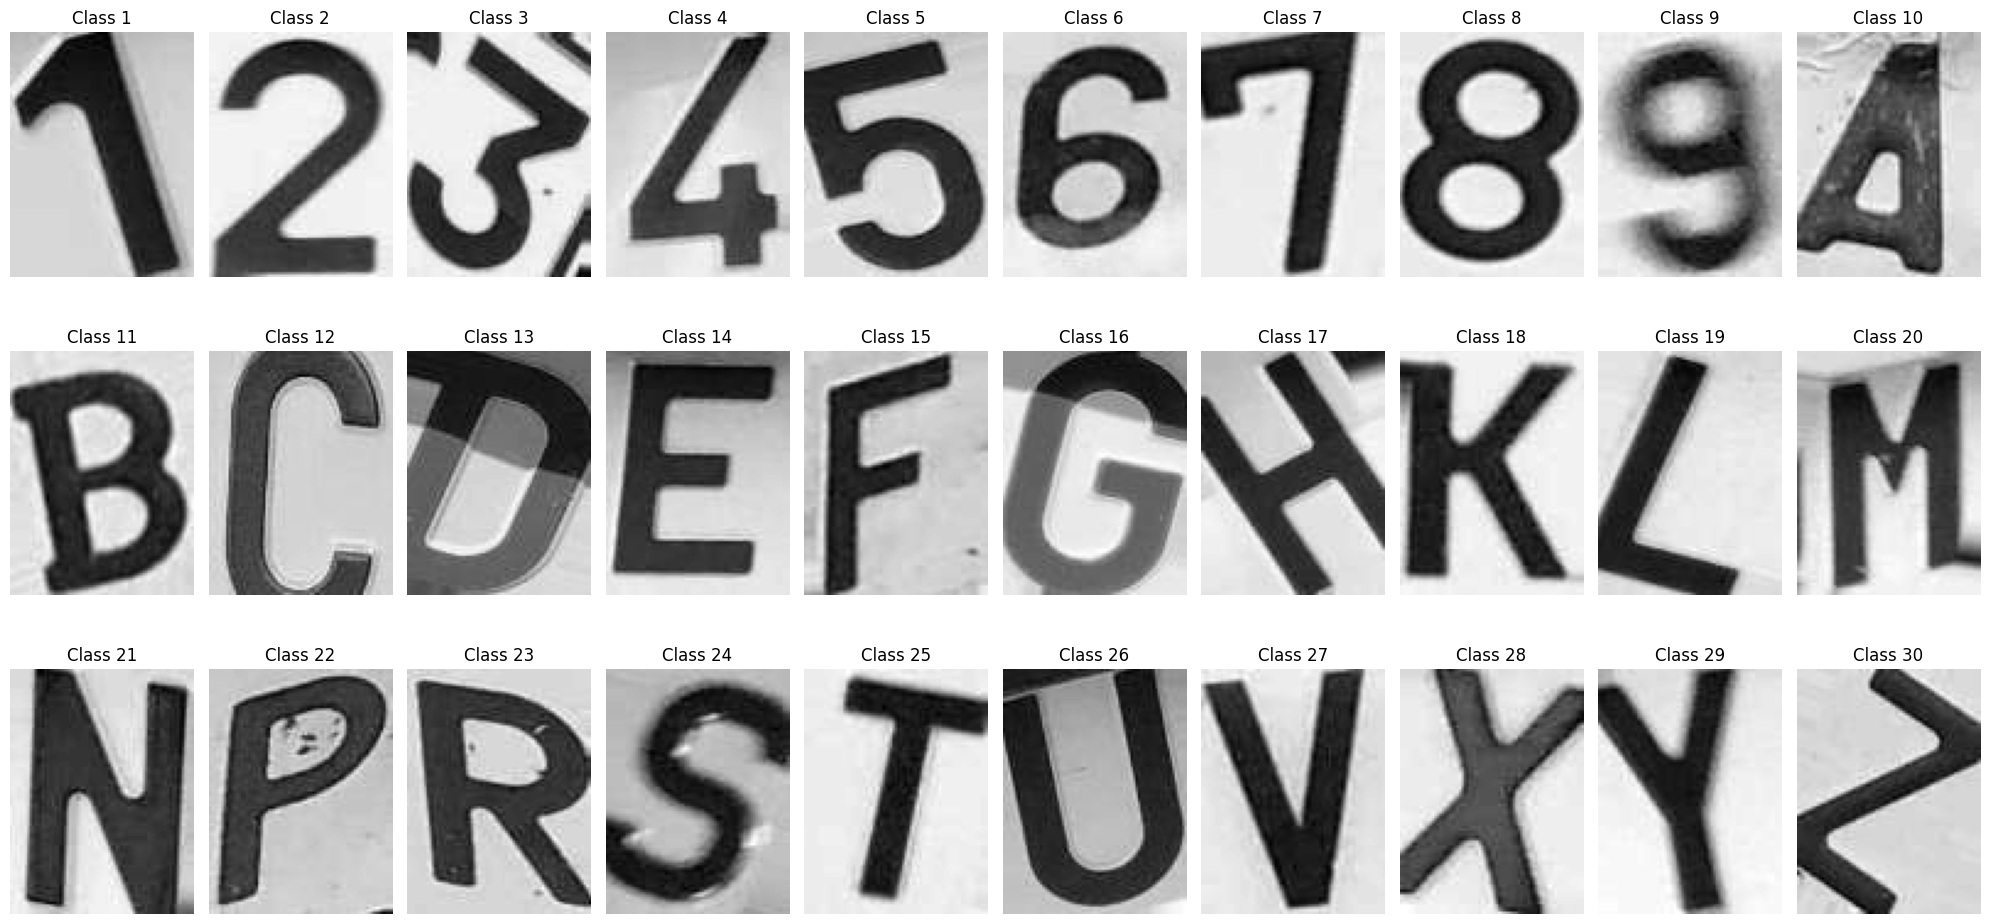

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Tạo figure cho hình ảnh
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 10))  # 4 hàng và 9 cột
axes = axes.flatten()  # Làm phẳng mảng axes để dễ dàng truy cập

# Biến để theo dõi chỉ số hình ảnh
img_index = 0

# Lặp qua các lớp từ 1 đến 30
for i in range(0, 31):
    # Tìm các chỉ số của lớp hiện tại
    listed = list(np.where(dataframed["label"] == i))
    listed = listed[0].tolist()

    # Kiểm tra xem có hình ảnh nào cho lớp này không
    if listed:  # Nếu danh sách không rỗng
        img = mpimg.imread(dataframed.iloc[int(listed[0])]['path'])  # Đọc hình ảnh
        axes[img_index].imshow(img, cmap='gray')  # Hiển thị hình ảnh
        axes[img_index].set_title(f"Class {i}")  # Đặt tiêu đề cho hình ảnh
        axes[img_index].axis('off')  # Tắt hiển thị trục
        img_index += 1  # Tăng chỉ số hình ảnh
    else:
        print(f"No images found for class {i}")  # Thông báo nếu không có hình ảnh cho lớp này

# Xóa các ô không sử dụng
for j in range(img_index, len(axes)):
    axes[j].axis('off')  # Tắt hiển thị trục cho các ô không sử dụng

plt.tight_layout()  # Tự động điều chỉnh khoảng cách giữa các hình ảnh
plt.show()  # Hiển thị tất cả hình ảnh


In [ ]:
import cv2 # Import cv2 module

def size_regulator(df, image_column='path', target_size=(28, 28)):
    # Khởi tạo danh sách rỗng để lưu trữ các hình ảnh sau khi điều chỉnh kích thước
    images = []
    i = 0  # Biến đếm để theo dõi số lượng hình ảnh đã xử lý

    # Lặp qua từng đường dẫn hình ảnh trong DataFrame
    for path in df[image_column]:
        # Đọc hình ảnh từ đường dẫn với chế độ xám
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        # Thay đổi kích thước hình ảnh về kích thước mục tiêu
        image = cv2.resize(image, target_size)

        # Thêm hình ảnh đã điều chỉnh vào danh sách
        images.append(image)

    print("done")  # Thông báo khi hoàn thành tất cả các hình ảnh
    return np.array(images)  # Trả về mảng NumPy chứa các hình ảnh đã điều chỉnh


dataframed_np = size_regulator(dataframed)

done


In [ ]:
dataframed_np.shape

(31440, 28, 28)

In [ ]:
# Reshape mảng thành (35500, 784)
reshaped_data = dataframed_np.reshape(31440, -1)  # Biến đổi thành (35500, 784)

# Tạo DataFrame từ dữ liệu đã reshape
df = pd.DataFrame(reshaped_data)

print(df.shape)

# Đảo màu
df_inverted = 255 - df

(31440, 784)


In [ ]:
# Thêm cột labels vào df
df_inverted['label'] = dataframed['label']

# Kiểm tra kết quả
print(df_inverted.head())
df = df_inverted

     0    1    2    3    4    5    6    7    8    9  ...  775  776  777  778  \
0   71   76   78   72   75   80   81   83   86   83  ...  167  168  103   71   
1  104  104  104  104  104  104  105  104  103  103  ...  108  105  104  104   
2  158  163  174  191  209  226  211  158  141  136  ...   85  104  181  179   
3   76   76   76   75   76   73   73   73   71   71  ...   66   73   80   74   
4   83   90   93   92   94   93   92   92   92   93  ...  207  187  173  183   

   779  780  781  782  783  label  
0   72   68   67   65   67      0  
1  104  103  103  106  106      0  
2  183  184  184  185  182      0  
3   51   52   54   60   65      0  
4  208  171  179  211  227      0  

[5 rows x 785 columns]


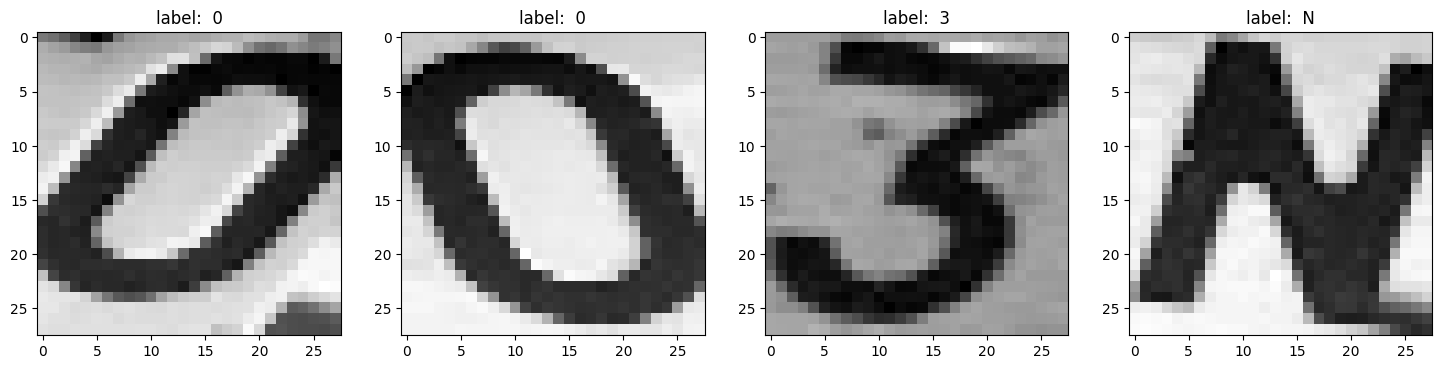

In [ ]:
# Hiển thị thử vài hình ảnh

X = df.drop(columns='label')
X.reset_index()

# Chuyển đổi dữ liệu hàng thứ 5 thành mảng 28x28
image_array1 = np.array(X.iloc[2]).reshape(28, 28)
image_array2 = np.array(X.iloc[22]).reshape(28, 28)
image_array3 = np.array(X.iloc[3333]).reshape(28, 28)
image_array4 = np.array(X.iloc[22222]).reshape(28, 28)

# Hiển thị ảnh
plt.figure(figsize=(18, 4))

plt.subplot(1,4,1)
plt.imshow(image_array1, cmap='binary')  # Hiển thị ảnh dưới dạng grayscale
plt.title(f"label:  {number_to_label(df['label'].iloc[2])}")

plt.subplot(1,4,2)
plt.imshow(image_array2, cmap='binary')  # Hiển thị ảnh dưới dạng grayscale
plt.title(f"label:  {number_to_label(df['label'].iloc[22])}")

plt.subplot(1,4,3)
plt.imshow(image_array3, cmap='binary')  # Hiển thị ảnh dưới dạng grayscale
plt.title(f"label:  {number_to_label(df['label'].iloc[3333])}")

plt.subplot(1,4,4)
plt.imshow(image_array4, cmap='binary')  # Hiển thị ảnh dưới dạng grayscale
plt.title(f"label:  {number_to_label(df['label'].iloc[22222])}")

plt.show()


In [ ]:

print("")
for row in image_array1:
    for value in row:
        print(f'{value:3}', end='')
    print()
print()

print("")
for row in image_array2:
    for value in row:
        print(f'{value:3}', end='')
    print()
print()

print("")
for row in image_array3:
    for value in row:
        print(f'{value:3}', end='')
    print()
print()

print("")
for row in image_array4:
    for value in row:
        print(f'{value:3}', end='')
    print()
print()


158163174191209226211158141136134131131130133132128126126120123127129129138160160150
129134139150156158141136134131130129129124119113105107121146162168161145151157153145
126127128127126132134130126127122117100 99118166214221222225223224224221221226211159
122124124126128130126124122119 99 93148217225225221220223222223222224223223225224226
120121123122123122118118113 92131208223217222222223221218219219220226223222223223223
116117118119118117113102 94158211214217220220217221174144129131144189216213227221222
117117117116115115102 92164218217219219222216147122119121119118114117124199217222222
113115117115113104 91140210212218218227205133118119120120121118114111106147214218217
111112112112105 92120208211212213218215139117118118116116118114111110 95143216215215
114115114108 92103198209211206213216153121117116115114115114113110 92106198216217215
110112105 91102189206210209210213161119115113113114114115113110 92 97189213218212214
111107 91 89172209207209209215175118110113112112112112113111 96 

### 3.1.2 Sử dụng Adaptive Thresholding cho dữ liệu trong dataset

In [ ]:
# Hàm để áp dụng adaptive thresholding
def apply_adaptive_threshold(row):
    # Reshape row thành hình ảnh 2D (28x28)
    image_reshaped = row[:-1].values.reshape(28, 28).astype(np.uint8)  # Loại bỏ cột label
    # Áp dụng adaptive thresholding
    thresh_image = cv2.adaptiveThreshold(
        image_reshaped,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        11,  # Kích thước cửa sổ
        2    # Hệ số trừ
    )
    return thresh_image.flatten()

# Áp dụng adaptive thresholding cho tất cả các hàng trong DataFrame
thresholded_images = df.apply(apply_adaptive_threshold, axis=1)

# Chuyển đổi kết quả về DataFrame
df_thresholded = pd.DataFrame(thresholded_images.tolist())
df_thresholded['label'] = df['label']  # Giữ lại cột label

# Kiểm tra kết quả
print(df_thresholded.head())

     0    1    2    3    4    5    6    7    8  9  ...  775  776  777  778  \
0    0  255  255    0    0    0    0    0    0  0  ...  255  255    0    0   
1  255  255  255  255  255  255  255    0    0  0  ...    0    0    0    0   
2  255  255  255  255  255  255  255  255    0  0  ...    0    0  255  255   
3  255  255  255  255  255    0    0    0    0  0  ...    0  255  255  255   
4    0  255  255  255  255  255  255  255  255  0  ...  255  255  255  255   

   779  780  781  782  783  label  
0    0    0    0    0  255      0  
1    0    0    0  255  255      0  
2  255  255  255  255  255      0  
3    0    0    0    0    0      0  
4  255    0    0  255  255      0  

[5 rows x 785 columns]


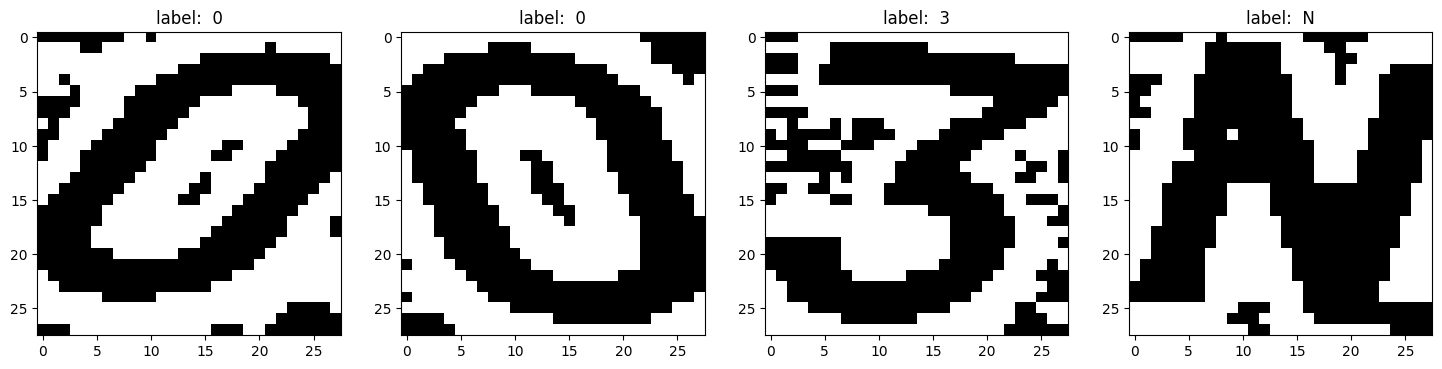

In [ ]:
# Hiển thị thử vài hình ảnh

X = df_thresholded.drop(columns='label')
X.reset_index()

# Chuyển đổi dữ liệu hàng thứ 5 thành mảng 28x28
image_array1 = np.array(X.iloc[2]).reshape(28, 28)
image_array2 = np.array(X.iloc[22]).reshape(28, 28)
image_array3 = np.array(X.iloc[3333]).reshape(28, 28)
image_array4 = np.array(X.iloc[22222]).reshape(28, 28)

# Hiển thị ảnh
plt.figure(figsize=(18, 4))

plt.subplot(1,4,1)
plt.imshow(image_array1, cmap='binary')  # Hiển thị ảnh dưới dạng grayscale
plt.title(f"label:  {number_to_label(df['label'].iloc[2])}")

plt.subplot(1,4,2)
plt.imshow(image_array2, cmap='binary')  # Hiển thị ảnh dưới dạng grayscale
plt.title(f"label:  {number_to_label(df['label'].iloc[22])}")

plt.subplot(1,4,3)
plt.imshow(image_array3, cmap='binary')  # Hiển thị ảnh dưới dạng grayscale
plt.title(f"label:  {number_to_label(df['label'].iloc[3333])}")

plt.subplot(1,4,4)
plt.imshow(image_array4, cmap='binary')  # Hiển thị ảnh dưới dạng grayscale
plt.title(f"label:  {number_to_label(df['label'].iloc[22222])}")

plt.show()

In [ ]:

print("label 0: ")
for row in image_array1:
    for value in row:
        print(f'{value:3}', end='')
    print()
print()

print("label 11: ")
for row in image_array2:
    for value in row:
        print(f'{value:3}', end='')
    print()
print()

print("label 15: ")
for row in image_array3:
    for value in row:
        print(f'{value:3}', end='')
    print()
print()

print("label 19: ")
for row in image_array4:
    for value in row:
        print(f'{value:3}', end='')
    print()
print()

label 0: 
255255255255255255255255  0  0255  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0255255  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0255  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0255255255255255255255255255255255255  0
  0  0  0  0  0  0  0  0  0  0  0  0  0255255255255255255255255255255255255255255255
  0  0255  0  0  0  0  0  0  0  0255255255255255255255255255255255255255255255255255
  0  0  0255  0  0  0  0  0255255255255255255255255255  0  0  0  0255255255255255255
255255255255  0  0  0  0255255255255255255255  0  0  0  0  0  0  0  0  0255255255255
255255255  0  0  0  0  0255255255255255255  0  0  0  0  0  0  0  0  0  0  0255255255
  0255  0  0  0  0  0255255255255255255  0  0  0  0  0  0  0  0  0  0  0  0255255255
255255  0  0  0  0255255255255255255  0  0  0  0  0  0  0  0  0  0  0  0255255255255
255  0  0  0  0255255255255255255  0  0  0  0  0  0255255  0  0  0  0255255255255255
255  0  0  0255255255255255255255  0  0  0  0  0255255 

In [ ]:
df_thresholded.to_csv('/content/drive/MyDrive/Yolov8/df_thresholded.csv', index=False)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Yolov8/df_thresholded.csv")
df

0    1    2    3    4  5  6  7    8    9  ...  775  776  777  778  \
0        0    0    0    0    0  0  0  0  255  255  ...  255  255  255  255   
1      255  255  255  255  255  0  0  0    0    0  ...    0    0  255  255   
2      255  255  255  255    0  0  0  0    0    0  ...    0    0    0    0   
3      255  255    0    0    0  0  0  0    0    0  ...    0    0    0    0   
4        0    0    0    0    0  0  0  0    0    0  ...    0    0    0    0   
...    ...  ...  ...  ...  ... .. .. ..  ...  ...  ...  ...  ...  ...  ...   
31435  255  255  255  255    0  0  0  0    0    0  ...    0    0  255    0   
31436  255    0    0    0    0  0  0  0    0    0  ...  255    0    0    0   
31437  255  255  255  255    0  0  0  0  255  255  ...    0    0    0    0   
31438  255  255  255    0    0  0  0  0    0    0  ...  255    0  255    0   
31439  255  255  255  255    0  0  0  0    0    0  ...    0    0    0  255   

       779  780  781  782  783  label  
0      255  255  255    0    0      0  
1        0  255  255  255  255      0  
2        0    0    0    0    0      0  
3        0    0    0    0  255      0  
4        0    0    0  255  255      0  
...    ...  ...  ...  ...  ...    ...  
31435  255  255  255  255  255     30  
31436    0  255  255  255  255     30  
31437  255  255  255  255  255     30  
31438  255  255  255  255  255     30  
31439    0    0    0    0  255     30  

[31440 rows x 785 columns]

In [ ]:
print(f"Các giá trị nằm trong cột label: {df['label'].unique()}")

Các giá trị nằm trong cột label: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]


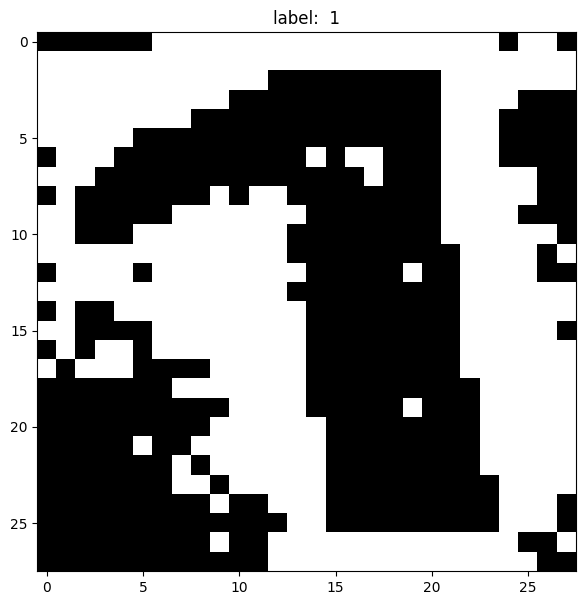

255255255255255255  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0255  0  0255
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0255255255255255255255255255  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0255255255255255255255255255255255  0  0  0  0255255255
  0  0  0  0  0  0  0  0255255255255255255255255255255255255255  0  0  0255255255255
  0  0  0  0  0255255255255255255255255255255255255255255255255  0  0  0255255255255
255  0  0  0255255255255255255255255255255  0255  0  0255255255  0  0  0255255255255
  0  0  0255255255255255255255255255255255255255255  0255255255  0  0  0  0  0255255
255  0255255255255255255255  0255  0  0255255255255255255255255  0  0  0  0  0255255
  0  0255255255255255  0  0  0  0  0  0  0255255255255255255255  0  0  0  0255255255
  0  0255255255  0  0  0  0  0  0  0  0255255255255255255255255  0  0  0  0  0  0255
  0  0  0  0  0  0  0  0  0  0  0  0  025525525525525525525525525

In [ ]:
def showIMGfromDF(df, i):
  row_i = np.array(df.iloc[i,:-1]).reshape(28, 28)
  # Hiển thị ảnh
  plt.figure(figsize=(7,7))
  plt.imshow(row_i, cmap='binary')  # Hiển thị ảnh dưới dạng grayscale
  plt.title(f"label:  {number_to_label(df['label'].iloc[i])}")
  plt.show()

  for row in row_i:
    for value in row:
        print(f'{value:3}', end='')
    print()
  print()

showIMGfromDF(df, 1999)

In [ ]:
# Tạo mảng arr chứ số lượng của mỗi chữ cái trong dataframe
arr = np.array([]);
for i in range(0,31):
  arr= np.append(arr,(df['label']==i).sum())
  print(f"{number_to_label(i)} : {(df['label']==i).sum()}  {round(((df['label']==i).sum()) / len(df) * 100, 2)}%")

0 : 1030  3.28%
1 : 1030  3.28%
2 : 1030  3.28%
3 : 1030  3.28%
4 : 1030  3.28%
5 : 1030  3.28%
6 : 1030  3.28%
7 : 1030  3.28%
8 : 1030  3.28%
9 : 1030  3.28%
A : 1010  3.21%
B : 1030  3.28%
C : 1020  3.24%
D : 1010  3.21%
E : 1010  3.21%
F : 1020  3.24%
G : 1020  3.24%
H : 1020  3.24%
K : 1010  3.21%
L : 1010  3.21%
M : 1020  3.24%
N : 1020  3.24%
P : 1010  3.21%
R : 1020  3.24%
S : 1020  3.24%
T : 1020  3.24%
U : 1010  3.21%
V : 1030  3.28%
X : 1010  3.21%
Y : 1010  3.21%
Z : 810  2.58%


In [ ]:
arr.sum()

31440.0

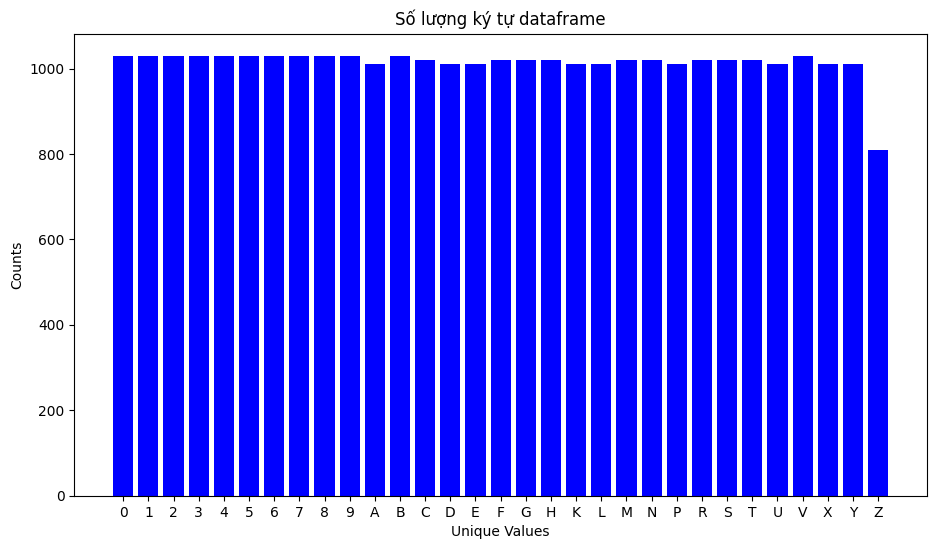

In [ ]:
plt.figure(figsize=(11, 6))
plt.bar(folders,arr, color ="blue")
plt.title('Số lượng ký tự dataframe')
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.show()

In [ ]:
df.isnull().sum()

0        0
1        0
2        0
3        0
4        0
        ..
780      0
781      0
782      0
783      0
label    0
Length: 785, dtype: int64

In [ ]:
df.duplicated().sum()

0

### 3.1.3 Bổ sung vào dataframe bộ dữ liệu tự thu thập

- Sau khi tiến hành thu thập dữ liệu như đã trình bày ở bước 2.5 thì thu thập được 1 folder có cấu trúc tương tự như folder dữ liệu gốc ở bước 3.1
- Tiến hành thực hiện xử lý tương tự như các bước trên ta thu được file csv gồm các ảnh mới mà nhóm em tự thu thập được nhằm bổ sung cho tập dữ liệu huấn luyện

In [ ]:
# Tải file csv chứa tập dữ liệu đã được thu thập và xử lý
df2 = pd.read_csv("/content/drive/MyDrive/Yolov8/dataframe_dataset1.csv")
df2

0   1   2   3    4    5    6    7    8    9  ...  775  776  777  778  \
0      0   0   0   0    0    0    0    0    0    0  ...    0    0    0    0   
1      0   0   0   0    0    3    9    9  255  255  ...    9    9    9    0   
2      0   0   0   0    0    0   89  127  244  255  ...  116    0    0    0   
3      0   0   0   0    0   41  255  255  255  255  ...  255  255  255   41   
4      0   0   0  10  106  255  255  255  255  255  ...  255  255  255  112   
...   ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2362   0   0   0   0    0    0    0    0    0    0  ...  255  255  255  255   
2363  96  96  96  96   96   96   96   96   96   96  ...  255  255  255  255   
2364   0   0   0   0    0    0    0    0    0    0  ...    0    0    0    0   
2365   0   0   0   0    0    0    0    0    0    0  ...  255  255  255  255   
2366   0   0   0   0    0    0    0  110  255  255  ...    0    0    0    0   

      779  780  781  782  783  label  
0       0    0    0    0    0      0  
1       0    0    0    0    0      0  
2       0    0    0    0    0      0  
3       0    0    0    0    0      0  
4      12    0    0    0    0      0  
...   ...  ...  ...  ...  ...    ...  
2362  255  255  255  255  143     31  
2363  255  255  255  187   96     31  
2364    0    0    0    0    0     31  
2365  255  255  255  255  255     31  
2366    0    0    0    0    0     31  

[2367 rows x 785 columns]

In [ ]:
# Loại bỏ class "Bg" có giá trị là 31
df2 = df2[df2['label'] != 31]

In [ ]:
# Kết hợp 2 dataframe lại
merged_df = pd.concat([df, df2], ignore_index=True)

In [ ]:
merged_df

0    1    2    3    4    5    6    7    8    9  ...  775  776  777  \
0        0    0    0    0    0    0    0    0  255  255  ...  255  255  255   
1      255  255  255  255  255    0    0    0    0    0  ...    0    0  255   
2      255  255  255  255    0    0    0    0    0    0  ...    0    0    0   
3      255  255    0    0    0    0    0    0    0    0  ...    0    0    0   
4        0    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
33677    0    0    0    0    0    0    0    0    0    0  ...    4  255  255   
33678   50  255  255  255  255  255  255  255  255   81  ...  255  155    0   
33679    0   11  150  150  150  150  150  150  150   32  ...  158    0    0   
33680   21  198  255  255  255  255  255  255  153    0  ...    0    0    0   
33681   70  255  255  255  255  255  255  255  255  255  ...  164  164  255   

       778  779  780  781  782  783  label  
0      255  255  255  255    0    0      0  
1      255    0  255  255  255  255      0  
2        0    0    0    0    0    0      0  
3        0    0    0    0    0  255      0  
4        0    0    0    0  255  255      0  
...    ...  ...  ...  ...  ...  ...    ...  
33677  255  255  255  255  255   36     28  
33678    0    0    0    0    0    0     29  
33679    0    0    0    0    0    0     29  
33680    0    0    0    0    0    0     29  
33681  255  255  255  255  255   70     30  

[33682 rows x 785 columns]

In [ ]:
df  = merged_df

## **3.2 Xây dựng mô hình CNN**

### 3.2.1 Chia tập dữ liệu và xử lý dữ liệu trước khi tiến hành huấn luyện

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical

# Đảm bảo cột "label" chứa nhãn và các cột từ "1x1" đến "28x28" chứa giá trị pixel

# Xác định các features (X) và nhãn (y)
X_cnn = df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)  # Reshape thành ảnh kích thước 28x28x1
y_cnn = df['label'].values

# Tiêu chuẩn hóa giá trị pixel về khoảng [0, 1]
X_cnn = X_cnn / 255.0

# One-hot encode nhãn
label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_cnn)

# Chia dữ liệu thành tập train và test
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_one_hot, test_size=0.2, random_state=42)

### 3.2.2 Xây dựng kiến trúc và huấn luyện mô hình

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()

# Lớp Convolutional đầu tiên
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Lớp Convolutional thứ hai
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Lớp Flatten
model.add(Flatten())

# Lớp Dense
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Lớp đầu ra
model.add(Dense(31, activation='softmax'))

# Biên dịch mô hình
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # Sử dụng 'sparse_categorical_crossentropy' nếu nhãn của bạn là số nguyên
    metrics=['accuracy']
)

# Xem tóm tắt mô hình
model.summary()

# Các callback để cải thiện quá trình huấn luyện
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Huấn luyện mô hình
history = model.fit(
    X_train_cnn,
    y_train_cnn,
    epochs=15,  # Bạn có thể điều chỉnh số epoch
    batch_size=128,  # Bạn có thể điều chỉnh kích thước batch
    validation_data=(X_test_cnn, y_test_cnn),
    callbacks=callbacks,
    verbose=1  # Hiển thị quá trình huấn luyện
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 26, 26, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 11, 11, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         819,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 903,423 (3.45 MB)

 Trainable params: 902,015 (3.44 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 155s 617ms/step - accuracy: 0.7130 - loss: 1.1151 - val_accuracy: 0.2784 - val_loss: 2.5197 - learning_rate: 0.0010
Epoch 2/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 196s 591ms/step - accuracy: 0.9782 - loss: 0.0772 - val_accuracy: 0.9878 - val_loss: 0.0643 - learning_rate: 0.0010
Epoch 3/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 141s 584ms/step - accuracy: 0.9910 - loss: 0.0343 - val_accuracy: 0.9947 - val_loss: 0.0211 - learning_rate: 0.0010
Epoch 4/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 147s 606ms/step - accuracy: 0.9944 - loss: 0.0217 - val_accuracy: 0.9979 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 5/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 200s 600ms/step - accuracy: 0.9957 - loss: 0.0163 - val_accuracy: 0.9947 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 6/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 201s 598ms/step - accuracy: 0.9959 - loss: 0.0144 - val_accuracy: 0.9979 - val_loss: 0.0125 - learning_rate: 0.0010
Epoch 7/15
237/237 ━━━━━━━━━━━━━━━━━━━━ 139s 586ms/step - accura

### 3.2.3 Đánh giá mô hình và lưu mô hình

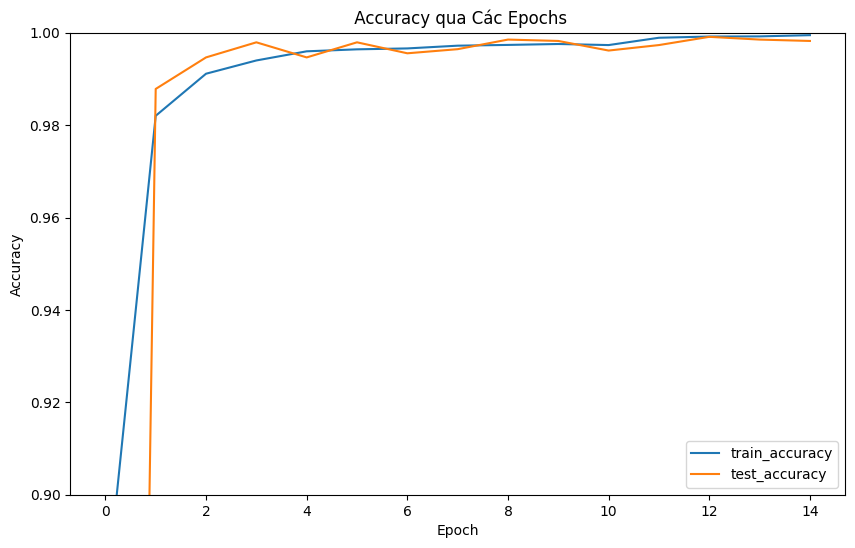

In [ ]:
import matplotlib.pyplot as plt

Epoch = range(1, 21,1)
# Vẽ biểu đồ accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(' Accuracy qua Các Epochs')
plt.ylim(0.9, 1)  # Đặt giới hạn trục y từ 0.9 đến 1
plt.legend()
plt.show()

106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step


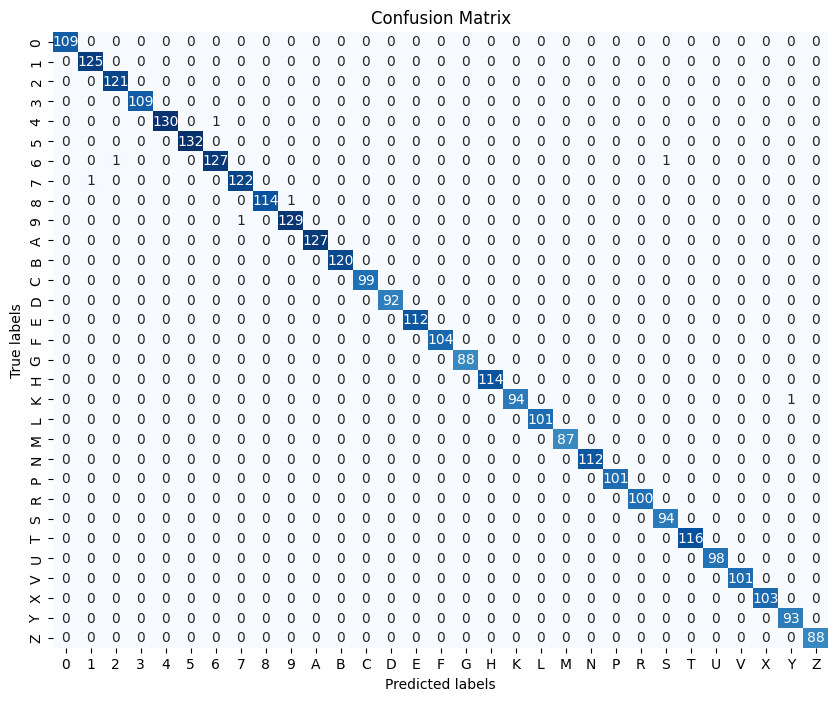

In [ ]:
import string

# Dự đoán nhãn trên tập test
y_pred_cnn = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)
y_true = np.argmax(y_test_cnn, axis=1)

# Tính toán ma trận nhầm lẫn
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Vẽ ma trận nhầm lẫn dưới dạng heatmap với nhãn là chữ cái
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=folders, yticklabels=folders)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Lưu mô hình dưới dạng HDF5
model.save('model_v4.h5')

print("Mô hình đã được lưu thành công dưới dạng HDF5.")

Mô hình đã được lưu thành công dưới dạng HDF5.


# **IV. Dự đoán trên dữ liệu thật**

### 4.1 Các hàm cần thiết

In [ ]:
from tensorflow.keras.models import load_model

label = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    'A': 10,
    'B': 11,
    'C': 12,
    'D': 13,
    'E': 14,
    'F': 15,
    'G': 16,
    'H': 17,
    'K': 18,
    'L': 19,
    'M': 20,
    'N': 21,
    'P': 22,
    'R': 23,
    'S': 24,
    'T': 25,
    'U': 26,
    'V': 27,
    'X': 28,
    'Y': 29,
    'Z': 30
}

dataframed = pd.DataFrame(columns = ['path', 'label'])

dataframed.head()

folders = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z']

label_number = label
label_word = folders

def number_to_label(number):
    # Kiểm tra xem số có hợp lệ không
    if number in label_number.values():
        # Tìm nhãn tương ứng
        for label, num in label_number.items():
            if num == number:
                return label
    else:
        return "Số không hợp lệ"


def format_license_plate(candidates):
    first_line = []
    second_line = []

    # Thêm các ký tự vào dòng đầu tiên hoặc dòng thứ hai
    for candidate, coordinate in candidates:
        if candidates[0][1][0] + 40 > coordinate[0]:  # Kiểm tra vị trí y
            first_line.append((candidate, coordinate[1]))
        else:
            second_line.append((candidate, coordinate[1]))

    # Hàm để lấy phần tử thứ hai của tuple
    def take_second(s):
        return s[1]

    # Sắp xếp các ký tự theo tọa độ y
    first_line = sorted(first_line, key=take_second)
    second_line = sorted(second_line, key=take_second)

    # Tạo chuỗi biển số
    if len(second_line) == 0:  # Nếu biển số có 1 dòng
        license_plate = "".join([str(ele[0]) for ele in first_line])
    else:  # Nếu biển số có 2 dòng
        license_plate = "".join([str(ele[0]) for ele in first_line]) + "-" + "".join([str(ele[0]) for ele in second_line])

    return license_plate

def filter_noise_candidates(candidates, height_factor=(9/10, 12/10), width_factor=(1/5, 17/10)):
    """
    Loại bỏ các ảnh nhiễu dựa trên kích thước.

    Parameters:
    - candidates: List of tuples (image, (y, x, w, h))
    - height_factor: Tuple chứa hệ số min và max cho chiều cao
    - width_factor: Tuple chứa hệ số min và max cho chiều rộng

    Returns:
    - filtered_candidates: List of tuples sau khi lọc
    """
    df_candidates = pd.DataFrame(candidates, columns=['image', 'coordinates'])
    df_candidates[['y', 'x', 'w', 'h']] = pd.DataFrame(df_candidates['coordinates'].tolist(), index=df_candidates.index)

    mean_height = df_candidates['h'].mean()
    std_height = df_candidates['h'].std()
    mean_width = df_candidates['w'].mean()
    std_width = df_candidates['w'].std()

    height_min = height_factor[0] * mean_height
    height_max = height_factor[1] * mean_height
    width_min = width_factor[0] * mean_width
    width_max = width_factor[1] * mean_width

    filtered_df = df_candidates[
        (df_candidates['h'] >= height_min) & (df_candidates['h'] <= height_max) &
        (df_candidates['w'] >= width_min) & (df_candidates['w'] <= width_max)
    ]

    filtered_candidates = list(filtered_df[['image', 'coordinates']].itertuples(index=False, name=None))
    return filtered_candidates


loaded_model = load_model('/content/drive/MyDrive/Yolov8/model_v4.h5')

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def draw_boxes_on_image(img, results, labels=None):
    """
    Vẽ các bounding boxes và nhãn lên ảnh dựa trên kết quả từ YOLOv8.

    Args:
    - img: Ảnh gốc (đối tượng PIL.Image hoặc numpy.ndarray).
    - results: Kết quả dự đoán từ mô hình YOLOv8.
    - labels: Danh sách các nhãn tương ứng với từng bounding box.

    Returns:
    - img_with_boxes: Ảnh đã được vẽ bounding boxes và nhãn.
    """
    # Chuyển đổi hình ảnh PIL sang định dạng OpenCV nếu cần
    if isinstance(img, Image.Image):
        image_cv = np.array(img)
        if img.mode != "RGB":
            image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGBA2BGR)
        else:
            image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)
    else:
        image_cv = img.copy()

    # Khởi tạo danh sách nhãn nếu không được cung cấp
    if labels is None:
        labels = [f"Class {int(cls)}" for result in results for cls in result.boxes.cls.cpu().numpy()]

    # Khởi tạo biến đếm để đảm bảo nhãn đúng với box
    label_idx = 0

    # Xử lý từng kết quả trong results
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()  # Lấy tọa độ bounding box: [x1, y1, x2, y2]
        scores = result.boxes.conf.cpu().numpy()  # Lấy confidence cho mỗi box
        classes = result.boxes.cls.cpu().numpy()  # Lấy class ids cho mỗi box

        for box, score, cls in zip(boxes, scores, classes):
            if len(box) < 4:
                print(f"Box không đủ tọa độ: {box}")
                continue  # Bỏ qua các box không đủ tọa độ

            x1, y1, x2, y2 = box.astype(int)

            # Vẽ bounding box
            color = (0, 0, 255)  # Màu đỏ cho box
            thickness = 3
            cv2.rectangle(image_cv, (x1, y1), (x2, y2), color, thickness)

            # Tạo nhãn tùy chỉnh
            if label_idx < len(labels):
                label = str(labels[label_idx])
            else:
                label = f'Class: {int(cls)} | {score:.2f}'
            label_idx += 1

            # Vẽ nhãn lên box
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1
            font_thickness = 2
            text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
            text_width, text_height = text_size
            text_x = x1
            text_y = y1 - 10 if y1 - 10 > 10 else y1 + 10

            cv2.rectangle(image_cv, (text_x - 3, text_y - text_height - 3), (text_x + text_width, text_y + 5), color, -1)
            cv2.putText(image_cv, label, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)

    # Chuyển đổi lại thành PIL Image nếu cần
    img_with_boxes = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
    img_with_boxes = Image.fromarray(img_with_boxes)

    # Hiển thị ảnh
    plt.figure(figsize=(12, 12))
    plt.imshow(img_with_boxes)
    plt.axis("off")
    plt.show()

    return img_with_boxes

# Ví dụ sử dụng hàm
# Giả sử bạn đã có filtered_candidates, img, results = predict_object(model_yolo, url)
# Và bạn đã có license_plate (chuỗi)


# all_labels = [license_plate]

# # Gọi hàm vẽ
# img_with_boxes = draw_boxes_on_image(img, results, labels=all_labels)

### 4.2 Hàm dự đoán

In [ ]:
def predict(filtered_candidates):
  plt.figure(figsize=(14, 10))

  candidates = []

    # Sử dụng hàm
  filtered_candidates2 = filter_noise_candidates(filtered_candidates)

  print(f"Số lượng candidates ban đầu: {len(filtered_candidates)}")
  print(f"Số lượng candidates sau khi lọc: {len(filtered_candidates2)}")

  for idx, (char_image, dim) in enumerate(filtered_candidates2):
      try:
          # Chuyển đổi thành mảng NumPy và chuẩn hóa
          img_array = np.array(char_image).astype('float32') / 255.0

          # Đảo màu (inverted color)
          # img_array = 1 - img_array

          # Kiểm tra hình dạng và kiểu dữ liệu
          print(f"Ảnh tại vị trí {idx}: shape={img_array.shape}, dtype={img_array.dtype}, min={img_array.min()}, max={img_array.max()}")

          # Chuyển đổi sang uint8 để resize
          img_uint8 = (img_array * 255).astype('uint8')

          # Kiểm tra kích thước ảnh
          if img_uint8.size == 0:
              print(f"Ảnh tại vị trí {idx} là trống.")
              continue  # Bỏ qua ảnh trống

          # Kiểm tra kích thước ảnh và thay đổi kích thước nếu cần
          if img_uint8.shape[:2] != (28, 28):
              try:
                  img_resized = cv2.resize(img_uint8, (28, 28), interpolation=cv2.INTER_LINEAR)
                  # print(f"Ảnh tại vị trí {idx} đã được thay đổi kích thước thành (28, 28).")
                  # Chuyển lại thành float32 và normalize
                  img_array = img_resized.astype('float32') / 255.0
                  img_array = 1 - img_array  # Đảo màu lại nếu cần
              except cv2.error as e:
                  print(f"Lỗi khi thay đổi kích thước ảnh tại vị trí {idx}: {e}")
                  continue

          # Thêm chiều kênh nếu cần (cho ảnh grayscale)
          if img_array.ndim == 2:
              img_array = np.expand_dims(img_array, axis=-1)  # Kích thước: (28, 28, 1)

          # Thêm kích thước batch
          img_array = np.expand_dims(img_array, axis=0)  # Kích thước: (1, 28, 28, 1)

          # Kiểm tra kích thước cuối cùng của img_array
          if img_array.shape != (1, 28, 28, 1):
              print(f"Kích thước cuối cùng của img_array tại vị trí {idx} không hợp lệ: {img_array.shape}")
              continue  # Bỏ qua ảnh này

          # Thực hiện dự đoán
          prediction = loaded_model.predict(img_array)
          #print(prediction)

          # Lấy lớp dự đoán
          predicted_class = np.argmax(prediction, axis=1)[0]  # Lấy giá trị lớp đầu tiên
          #print(f"Lớp dự đoán cho hình ảnh tại vị trí {idx}: {number_to_label(predicted_class)}")
          print(predicted_class)

      except cv2.error as e:
          print(f"Lỗi của OpenCV tại vị trí {idx}: {e}")
          continue  # Bỏ qua ảnh này và tiếp tục với ảnh tiếp theo
      except Exception as e:
          print(f"Đã xảy ra lỗi tại vị trí {idx}: {e}")
          continue  # Bỏ qua ảnh này và tiếp tục với ảnh tiếp theo

      candidates.append((number_to_label(predicted_class),dim))

      img_array = 1 - img_array  # Đảo màu lại nếu cần
      # Hiển thị ảnh và kết quả dự đoán
      plt.subplot(1, len(filtered_candidates), idx + 1)
      plt.imshow(img_array.squeeze(), cmap='gray')  # Squeeze để loại bỏ các chiều đơn
      plt.axis('off')
      plt.title(number_to_label(predicted_class))

  plt.tight_layout()
  plt.show()

  # Định dạng biển số
  license_plate = format_license_plate(candidates)
  print("Biển số xe:", license_plate)

  all_labels = [license_plate]

  # Gọi hàm vẽ
  img_with_boxes = draw_boxes_on_image(img, results, labels=all_labels)


### **4.3 Tiến Hành Test thử**

In [ ]:

# Load YOLO model /content/drive/MyDrive/Yolov8/best (1).pt,
model_yolo = YOLO('/content/drive/MyDrive/Yolov8/best_final.pt')

In [ ]:
# https://thegioimercedes.vn/wp-content/uploads/2022/01/chon-bien-so-xe-hop-tuoi-0.jpg
# https://nghenghiepcuocsong.vn/wp-content/uploads/2023/08/TDU07433.jpg
# https://cdnphoto.dantri.com.vn/OMDlXuTbVk4hH3JqKK7jnx56fWw=/thumb_w/960/2020/11/04/xe-1604452536142.jpeg
# https://xedapkhanhhiep.com/wp-content/uploads/2022/07/bien-so-xe-99-o-dau-1.jpg
# https://cms-i.autodaily.vn/du-lieu/2016/10/30/DSC_5794%20copy.jpg
# https://blogcdn.muaban.net/wp-content/uploads/2022/10/31105942/bien-so-xe-79-co-y-nghia-gi-1-1.jpg
# https://thongtingiaypheplaixe.com/wp-content/uploads/2024/01/bien-so-xe-quang-tri-1.jpg
# https://imgcdn.tapchicongthuong.vn/thumb/w_1000/cartime-media/20/10/13/bien_so_xe_lam_dong_1.jpg
# https://imagev3.vietnamplus.vn/w1000/Uploaded/2024/pcfo/2023_03_05/0503_sua_bien_so.jpg.webp
# https://suzuki-binhduong.vn/wp-content/uploads/2021/04/bien-so-xe-noi-len-dieu-gi-1.jpg
# https://tracuubienso.com/images/mHInyKd.jpg


url = "https://inmax.vn/wp-content/uploads/2022/10/bien-so-tu-quy-hai-duong.jpg"



0: 416x640 1 bien_so, 462.1ms
Speed: 4.4ms preprocess, 462.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs/detect/predict3
Biển số xe đã được lưu.
image0.jpg


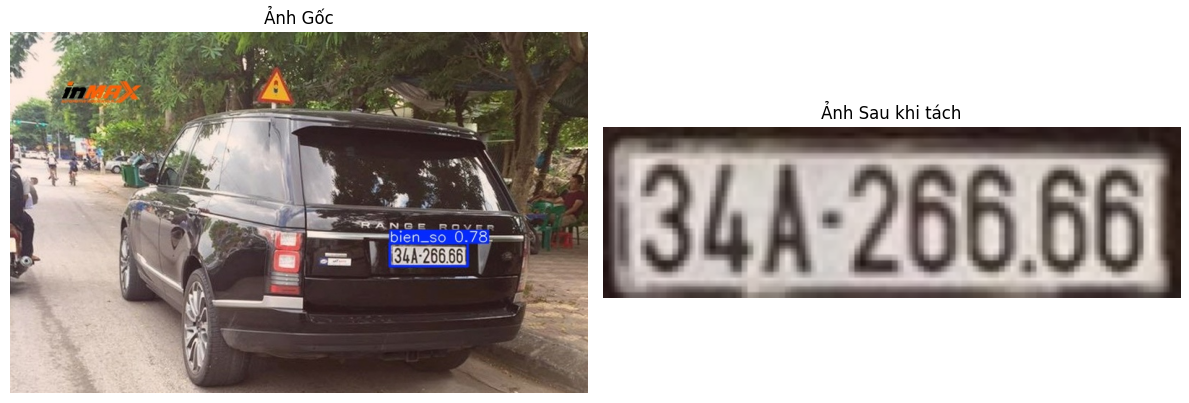

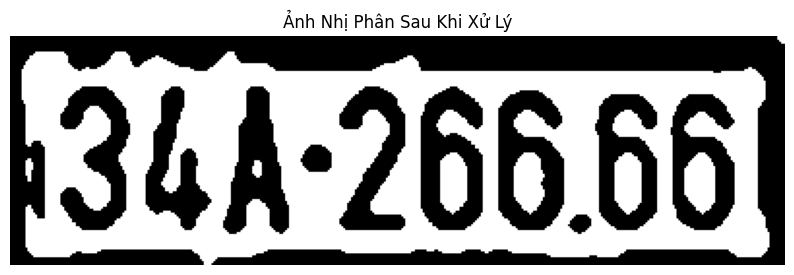

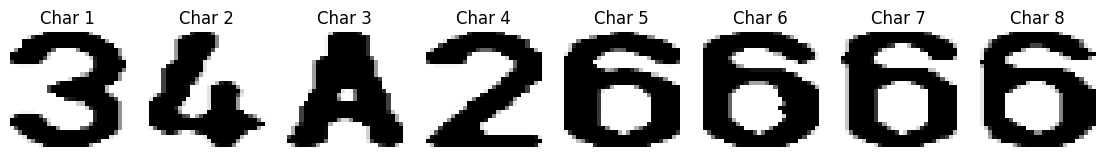

Số lượng candidates ban đầu: 8
Số lượng candidates sau khi lọc: 8
Ảnh tại vị trí 0: shape=(74, 36), dtype=float32, min=0.0, max=1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
3
Ảnh tại vị trí 1: shape=(74, 34), dtype=float32, min=0.0, max=1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4
Ảnh tại vị trí 2: shape=(76, 34), dtype=float32, min=0.0, max=1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
10
Ảnh tại vị trí 3: shape=(74, 34), dtype=float32, min=0.0, max=1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2
Ảnh tại vị trí 4: shape=(74, 32), dtype=float32, min=0.0, max=1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
6
Ảnh tại vị trí 5: shape=(72, 34), dtype=float32, min=0.0, max=1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
6
Ảnh tại vị trí 6: shape=(70, 32), dtype=float32, min=0.0, max=1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
6
Ảnh tại vị trí 7: shape=(70, 33), dtype=float32, min=0.0, max=1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
6


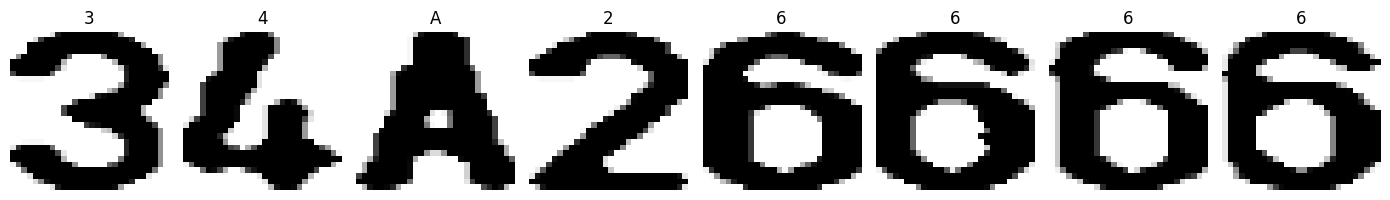

Biển số xe: 34A26666


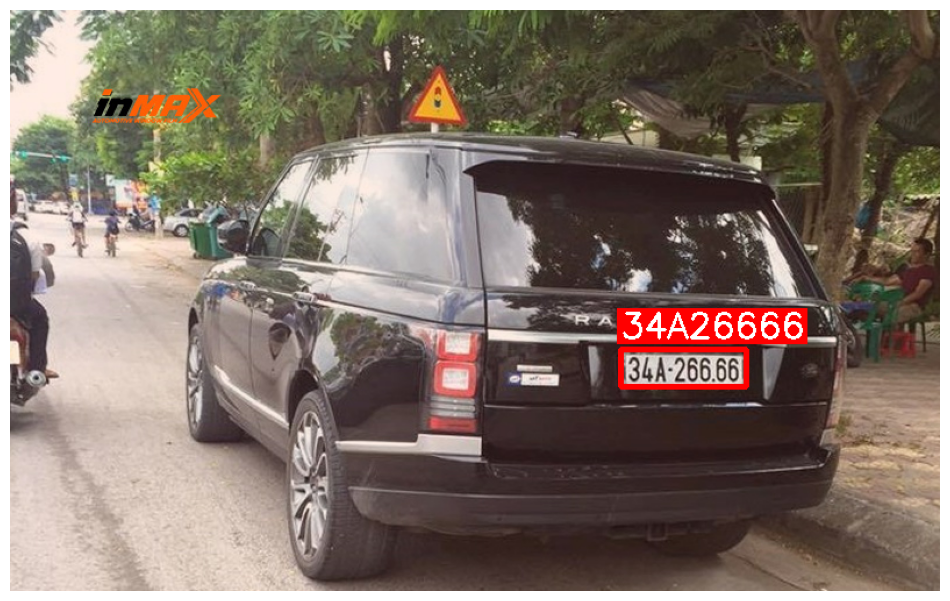

In [ ]:
filtered_candidates, img, results = predict_object(model_yolo, url)

predict(filtered_candidates)